In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
df = pd.read_csv('ai_job_dataset.csv')

In [3]:
df.head()

,job_id,job_title,salary_usd,salary_currency,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name
0,AI00001,AI Research Scientist,90376,USD,SE,CT,China,M,China,50,"Tableau, PyTorch, Kubernetes, Linux, NLP",Bachelor,9,Automotive,2024-10-18,2024-11-07,1076,5.9,Smart Analytics
1,AI00002,AI Software Engineer,61895,USD,EN,CT,Canada,M,Ireland,100,"Deep Learning, AWS, Mathematics, Python, Docker",Master,1,Media,2024-11-20,2025-01-11,1268,5.2,TechCorp Inc
2,AI00003,AI Specialist,152626,USD,MI,FL,Switzerland,L,South Korea,0,"Kubernetes, Deep Learning, Java, Hadoop, NLP",Associate,2,Education,2025-03-18,2025-04-07,1974,9.4,Autonomous Tech
3,AI00004,NLP Engineer,80215,USD,SE,FL,India,M,India,50,"Scala, SQL, Linux, Python",PhD,7,Consulting,2024-12-23,2025-02-24,1345,8.6,Future Systems
4,AI00005,AI Consultant,54624,EUR,EN,PT,France,S,Singapore,100,"MLOps, Java, Tableau, Python",Master,0,Media,2025-04-15,2025-06-23,1989,6.6,Advanced Robotics


In [4]:
df.shape

(15000, 19)

In [5]:
df.isnull().sum()

job_id                    0
job_title                 0
salary_usd                0
salary_currency           0
experience_level          0
employment_type           0
company_location          0
company_size              0
employee_residence        0
remote_ratio              0
required_skills           0
education_required        0
years_experience          0
industry                  0
posting_date              0
application_deadline      0
job_description_length    0
benefits_score            0
company_name              0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   job_id                  15000 non-null  object 
 1   job_title               15000 non-null  object 
 2   salary_usd              15000 non-null  int64  
 3   salary_currency         15000 non-null  object 
 4   experience_level        15000 non-null  object 
 5   employment_type         15000 non-null  object 
 6   company_location        15000 non-null  object 
 7   company_size            15000 non-null  object 
 8   employee_residence      15000 non-null  object 
 9   remote_ratio            15000 non-null  int64  
 10  required_skills         15000 non-null  object 
 11  education_required      15000 non-null  object 
 12  years_experience        15000 non-null  int64  
 13  industry                15000 non-null  object 
 14  posting_date            15000 non-null

In [8]:
df.describe()

,salary_usd,remote_ratio,years_experience,job_description_length,benefits_score
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,115348.965133,49.483333,6.253200,1503.314733,7.504273
std,60260.940438,40.812712,5.545768,576.127083,1.450870
min,32519.000000,0.000000,0.000000,500.000000,5.000000
25%,70179.750000,0.000000,2.000000,1003.750000,6.200000
50%,99705.000000,50.000000,5.000000,1512.000000,7.500000
75%,146408.500000,100.000000,10.000000,2000.000000,8.800000
max,399095.000000,100.000000,19.000000,2499.000000,10.000000


## Exploratory Data Analysis

## Salary Distribution

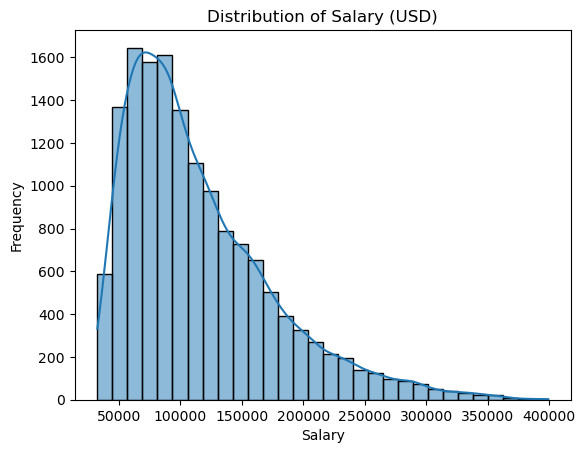

In [9]:
sns.histplot(df['salary_usd'], bins=30, kde=True)
plt.title('Distribution of Salary (USD)')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.show()

## Outlier in Salary

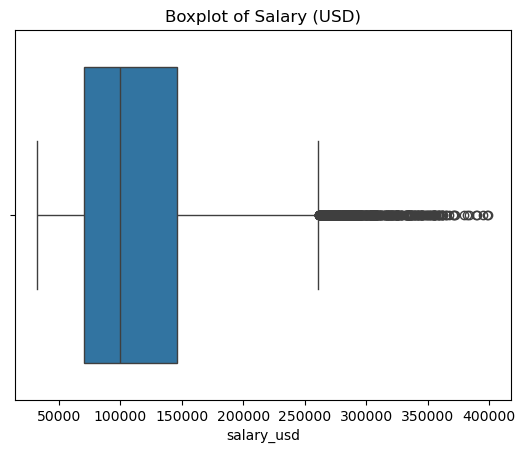

In [10]:
sns.boxplot(x=df['salary_usd'])
plt.title('Boxplot of Salary (USD)')
plt.show()

# Preprocessing: Handle categorical & ordinal features

## Salary vs. Experience Level

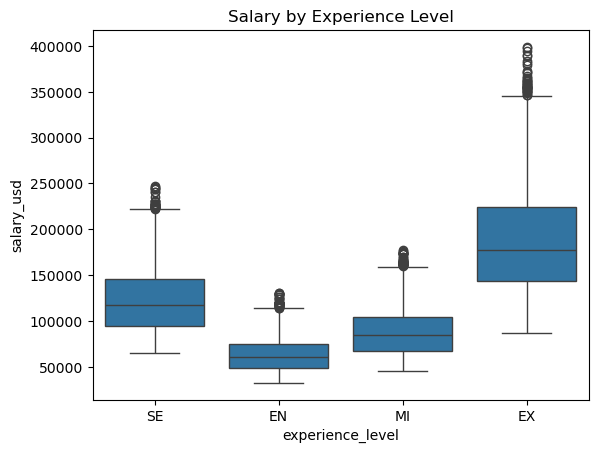

In [11]:
sns.boxplot(x='experience_level', y='salary_usd', data=df)
plt.title('Salary by Experience Level')
plt.show()

In [12]:
# Map ordinal features
# Experience level
exp_map = {'EN': 0, 'MI': 1, 'SE': 2, 'EX': 3}
df['experience_level'] = df['experience_level'].map(exp_map)

# Education level (sample map — adjust based on actual data)
edu_map = {
    'High School': 0,
    'Associate': 1,
    'Bachelor': 2,
    'Master': 3,
    'PhD': 4
}
df['education_required'] = df['education_required'].map(edu_map)

# Company size
size_map = {'S': 0, 'M': 1, 'L': 2}
df['company_size'] = df['company_size'].map(size_map)

## Define Features and Target

In [13]:
target = 'salary_usd'

features = [
    'experience_level', 'education_required', 'company_size', 'remote_ratio',
    'employment_type','company_location', 'employee_residence'
]

X = df[features]
y = df[target]

## ColumnTransformer for encoding

In [14]:
# Define column types
numeric_features = ['experience_level', 'education_required', 'company_size', 'remote_ratio']
categorical_features = ['employment_type','company_location', 'employee_residence']

# Preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

### Create pipeline with mode

In [15]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

### Train-test split and model training

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## Evaluate performance

In [17]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

RMSE: 22421.45
R² Score: 0.86
